In [31]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [57]:
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32*32),
            nn.BatchNorm1d(32*32),
            nn.LeakyReLU(0.2),
            nn.Linear(32*32, 128*7*7),
            nn.BatchNorm1d(128*7*7),
            nn.LeakyReLU(0.2)
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)
        x = self.conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x

In [38]:
train_dataset = datasets.MNIST(root="./datasets/", train=True, transform=transforms.ToTensor(), download=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

In [54]:
import matplotlib.pyplot as plt
def plot(G):
    G.eval()
    images = G(torch.randn(16, 100).to(device))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

In [59]:
def train(G, D, dataloader, epochs, save_path):
    os.makedirs(save_path, exist_ok=True)
    G.to(device)
    D.to(device)
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    for e in range(epochs):
        G.train()
        D.train()
        loop = tqdm(dataloader, total=len(dataloader), desc=f'Epoch [{e+1}/{epochs}]')
        for image, _ in loop:
            real_images = image.to(device)*2 - 1
            
            # ============ 训练判别器 ============
            outputs = D(real_images)
            real_labels = torch.ones_like(outputs, device=device)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            fake_images = G(torch.randn(128, 100).to(device))
            outputs = D(fake_images.detach())
            fake_labels = torch.zeros_like(outputs, device=device)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            # ============ 训练生成器 ============
            fake_images = G(torch.randn(128, 100).to(device))
            outputs = D(fake_images)
            real_labels = torch.ones_like(outputs, device=device)
            g_loss = criterion(outputs, real_labels)

            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            loop.set_postfix({'d_loss': f'{d_loss.item():.4f}', 'g_loss': f'{g_loss.item():.4f}', 'D(x)': f'{real_score.mean().item():.4f}', 'D(G(z))': f'{fake_score.mean().item():.4f}'})
        torch.save(G.state_dict(), os.path.join(save_path, f'{e}_weight.pth'))
        plot(G)

Epoch [1/100]: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s, d_loss=0.6327, g_loss=0.9426, D(x)=0.6491, D(G(z))=0.1354]


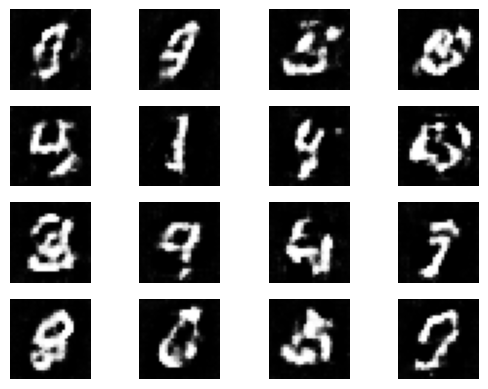

Epoch [2/100]: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s, d_loss=0.6662, g_loss=1.3962, D(x)=0.6965, D(G(z))=0.1868]


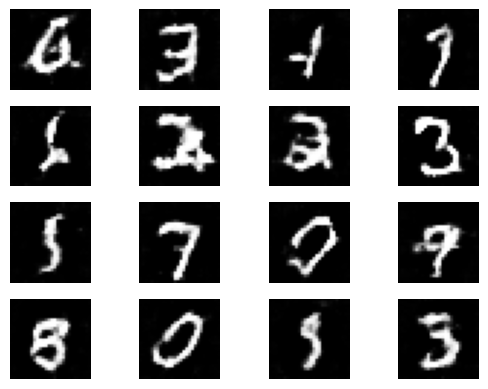

Epoch [3/100]: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s, d_loss=0.6006, g_loss=2.9805, D(x)=0.8591, D(G(z))=0.3193]


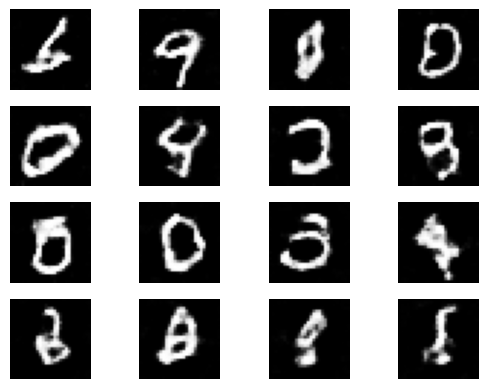

Epoch [4/100]: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s, d_loss=0.8594, g_loss=0.9718, D(x)=0.5765, D(G(z))=0.1159]


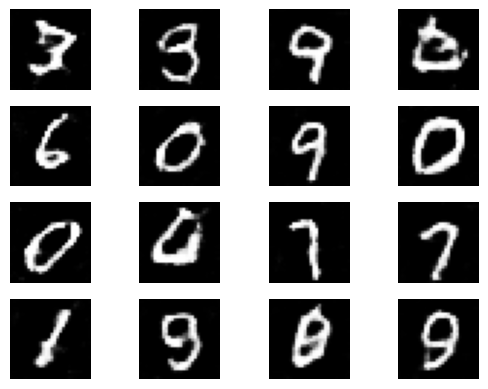

Epoch [5/100]:  36%|███▌      | 169/469 [00:05<00:10, 28.40it/s, d_loss=0.6834, g_loss=3.1598, D(x)=0.8738, D(G(z))=0.3625]


KeyboardInterrupt: 

In [60]:
G = Generator(100)
D = Discriminator()
train(G, D, train_loader, 100, './mnist')